# Truer Ratings: Normalizing Google Reviews Data
## By Ivy Nangalia and Evan Flynn

### Importing The Data

In [544]:
# importing libraries
import numpy as np
import pandas as pd

In [545]:
# initializing column names
colnames = ['User', 'church_avg', 'resort_avg', 'beach_avg', 'park_avg', 'theater_avg',
       'museum_avg', 'mall_avg', 'zoo_avg', 'restaurants_avg', 'bars_avg',
       'local_services_avg', 'burger_pizza_avg', 'hotel_avg', 'juice_avg',
       'art_avg', 'dance_avg', 'pool_avg', 'gym_avg', 'bakery_avg',
       'beauty_avg', 'spa_avg', 'cafe_avg', 'viewpoint_avg', 'monument_avg',
       'garden_avg']

In [546]:
#used copilot for pandas read_csv function
data = pd.read_csv('google_review_ratings.csv')
data.columns = colnames
# used copilot to drop user column
data = data.drop("User", axis=1) 
data = data.fillna(0.0)

We ran into an issue where `data["local_services_avg"]` was imported as an array of strings instead of floats. We had a hard time changing the datatype of the entire column because at `data["local_services_avg"][2712]` the value was `"2\t2"`. We ended up removing this anomaly and typecasting the rest of the data using a for loop.

In [547]:
x = pd.array(np.zeros(len(data["local_services_avg"])))

for i in range(0, len(data["local_services_avg"])-1):
    try:
        x[i] = float(data["local_services_avg"][i])
    except:
        print(i)
        x[i] = float(0.0)

data["local_services_avg"] = x

2712


### Initial Data Exploration

Our focus was to explore voluntary response bias in reviews. Statistically, we'd expect to see a mean rating of 2.5 stars per user (assuming a 1-5 scale). However, it appears that the mean rating was closer to 2, which indicates a right skew. 

Note: When testing out giving low ratings, we noted that Google Maps does not allow users to give reviews below 1 star. We still chose to use a 2.5 value since there were some average values below 1, indicating that this dataset perhaps accounts for that, or users were able to give zero stars.

In [548]:
x = data["bars_avg"].to_list()
print(sorted(x)[0:10]) # there are values lower than 1

[0.81, 0.81, 0.82, 0.82, 0.82, 0.82, 0.82, 0.82, 0.82, 0.83]


In [549]:
# calculating user_average
data["user_average"] = data.apply(
    lambda row: row[row.apply(
        lambda x: isinstance(x, (int, float))) # ensures average only counts floats
        & (row != 0)].mean(), #ensures average does not count zeros
        axis=1)
# copilot was used for lambda aggfunc
print(data["user_average"].mean())

2.120645714017358


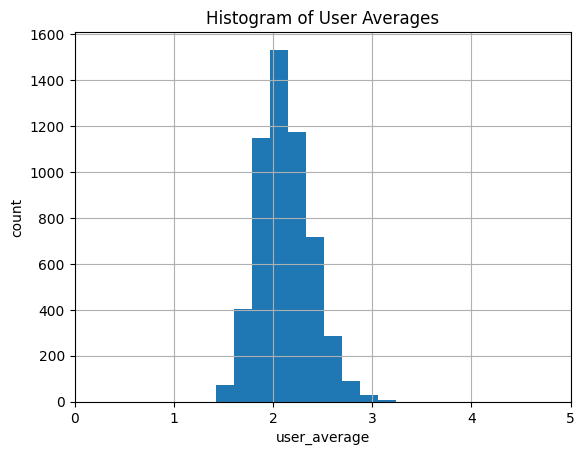

In [550]:
import matplotlib.pyplot as plt
data["user_average"].hist()
plt.xlim(0, 5) # used copilot for matplotlib help
plt.xlabel("user_average")
plt.ylabel("count")
plt.title("Histogram of User Averages")
plt.show()


We aimed to correct for this by getting the difference between the sample mean (of the user) and the expected mean (2.5 stars).

In [551]:
data["skew"] = data["user_average"] - 2.5

### Fixing the Skew

In [552]:
unskew = data # initializing a new dataframe to "unskew" the data
x = unskew["skew"]
unskew = unskew.drop("skew", axis=1)
unskew["skew"] = x # get rid of initial mean function

We ran into an issue when just mutating `unskew` where every value became `NaN`. We used an intermediate variable `x` to ensure we isolated the values, which fixed the issue.

In [553]:
unskew = unskew.apply(lambda row: row[row.apply # subtracts skew from non-zero values
                             (lambda y: isinstance(y, (int, float)))
                             & (row != 0)]
                             - x, # subtracting the difference
                             axis=0)
unskew = unskew.fillna(0)

In [554]:
unskew = unskew.drop(labels=["user_average"], axis=1)
unskew["user_average"] = unskew.apply(lambda row: row[row.apply(
    lambda x: isinstance(x, (int, float))) 
    & (row != 0)].mean(), # creates new user average based on non-zero values
    axis=1)

In [576]:
for n in unskew["user_average"]:
    if round(n,ndigits=1) != 2.5: 
        # some values are near 2.5 but not 2.5 exactly
        print(n)
# no values were observed that were greater than 0.1 away from 2.5

We normalized the means of all users around 2.5 using the following formula:
$$\text{Let } \bar{x}_i = \text{the original user's mean} $$
$$d_i = \bar{x}_i - 2.5$$
$$\sum{x_i + d_i} = x_j$$
$$\bar{x}_j = 2.5$$

$x_j$ is represented as the `normalized` dataframe.

In [555]:
# copy and pasted existing copilot code, and used .to_dict() method
raw = data.apply(lambda col: col[col.apply(lambda x: isinstance(x, (int, float))) & (col != 0)].mean(), axis= 0).to_dict()
normalized = unskew.apply(lambda col: col[col.apply(lambda x: isinstance(x, (int, float))) & (col != 0)].mean(), axis= 0).to_dict()
# fix normalized skew (which was NaN since there are no non-zero values for the function to average)
normalized["skew"] = 0.0

In [556]:
means = pd.DataFrame([raw, normalized]).transpose()
means.columns = ["raw", "normalized"]
means = means.drop(["skew", "user_average"], axis=0)
means["difference"] = means["normalized"] - means["raw"]
means


,raw,normalized,difference
church_avg,1.509677,1.898089,0.388412
resort_avg,2.358613,2.743645,0.385031
beach_avg,2.491157,2.870749,0.379591
park_avg,2.796886,3.176240,0.379354
theater_avg,2.958941,3.338295,0.379354
museum_avg,2.893490,3.272844,0.379354
mall_avg,3.351395,3.730749,0.379354
zoo_avg,2.540795,2.920150,0.379354
restaurants_avg,3.126019,3.505373,0.379354
bars_avg,2.832729,3.212083,0.379354


The rest of our values all looked very similar, but the `garden_avg` difference appeared to be an outlier. The difference was caused by the low number of non-zero observations in `garden_avg` (2).

In [557]:
n = 0
for value in data["garden_avg"]:
    if value > 0.0:
        n +=1
print(n)
# removing "garden_avg" because of low n count
means = means.drop("garden_avg", axis=0)

2


After removing this outlier, we found that the average difference between means ends up being a constant around 0.387. For the rest of this document, we will refer to this constant as $k$.

$$k = \frac{\sum{\bar{x}_j-\bar{x}_i}}{n}$$
$$\text{for } n = \text{number of categories}$$

In [580]:
k = float(means["difference"].mean())
print(k)

0.3873730897663091


In [561]:
means["difference"].max() - means["difference"].min() # the difference between values is not high

0.03270381610615902

Our normalization process normalized the category averages to better fit a bell curve, like one would expect to see among a large range of observations of a continuous variable.

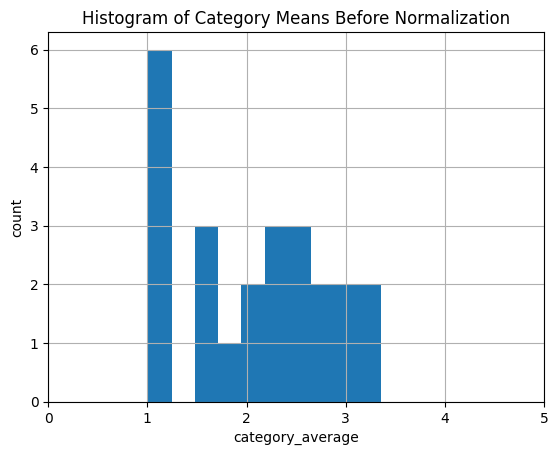

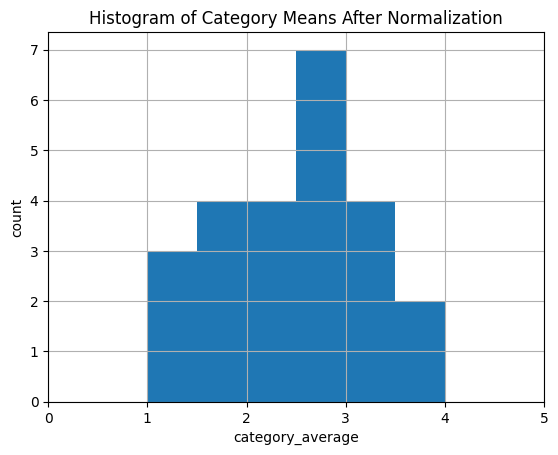

In [579]:
means["raw"].hist()
plt.title("Histogram of Category Means Before Normalization")
plt.xlim(0, 5)
plt.xlabel("category_average")
plt.ylabel("count")
plt.show()

means["normalized"].hist(range=(0,5))
plt.title("Histogram of Category Means After Normalization")
plt.xlim(0, 5)
plt.xlabel("category_average")
plt.ylabel("count")
plt.show()

### Building a model.

We decided to use a linear model to adjust a given sample average ($x$) to a more likely average rating ($\bar{\mu}$), modeled by:
$$\bar{\mu} = -\frac{k}{2.5} * (x-5) + x$$
We arrived at this formula for a few reasons:
1. We decided to use a linear model, rather than an exponential one, because we found that people tend to underrate things; google reviews had a negative bias.
2. Therefore, we did not want to subtract from higher ratings, but we did want to add to lower ratings.
3. We wanted to ensure the line went through $(5, 5)$ to ensure we don't boost ratings past a 5/5 stars.
4. We wanted the average value of the line (depicted in red) to be $2.5 + k$ to reflect the adjustment in ratings

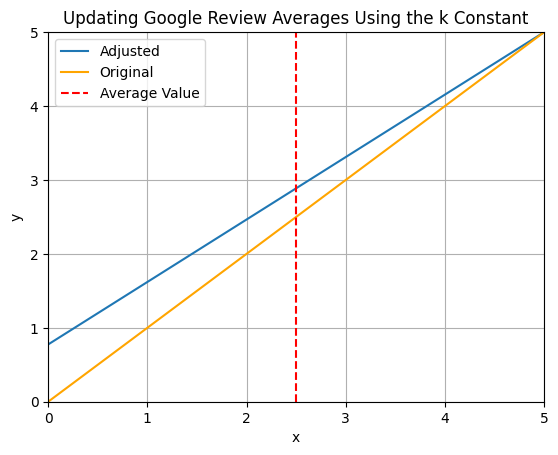

In [634]:
import numpy as np
def adjust(x: float) -> float: # creating a method to adjust x
    adjusted = (-k / 2.5) * (x - 5) + x
    return adjusted

# matplotlib code was assisted by copilot

x = np.linspace(0, 5, 100)  # Generate 100 points between 0 and 5
y = adjust(x)

plt.plot(x, y, label='Adjusted')
plt.plot(x, x, color='orange', label='Original')

plt.xlim(0,5)
plt.ylim(0,5)
plt.xlabel('Input')
plt.vlines(2.5, ymin=0, ymax=5, colors="red", # draw a line at the average
           label="Average Value", linestyles="dashed") 
plt.ylabel('y')
plt.title('Updating Google Review Averages Using the k Constant')
plt.grid(True)

plt.legend()
plt.show()
